In [6]:
import argparse
import itertools
from itertools import product
import glob
import os
import random
import sys
import numpy as np
import pandas as pd
import scipy.sparse as ss
import scipy.sparse.linalg as sl
import scipy.spatial
from scipy.linalg import sqrtm
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
#from scipy.stats import ortho_group

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torch_scatter as ts
from torch_sparse import SparseTensor
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.datasets import DGraphFin
from torch_geometric.nn import GCNConv
#from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.typing import SparseTensor
from torch_geometric.utils import (
    to_undirected, 
    to_networkx, 
    from_networkx, 
    one_hot, 
    to_scipy_sparse_matrix
)

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    precision_recall_fscore_support
)
#from sklearn.model_selection import StratifiedKFold, train_test_split
#from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#import seaborn as sns

from tqdm.notebook import tqdm
import geotorch
#import networkx as nx
#import umap.umap_ as umap
#import streamlit as st

import autograd.numpy as anp
#import pymanopt
#import pymanopt.manifolds
#import pymanopt.optimizers
##from pymanopt.manifolds import (
  #  Euclidean, 
   # Product, 
   # SpecialOrthogonalGroup,  
   # Stiefel
#)
#from pymanopt.optimizers import SteepestDescent

import local2global as l2g
import local2global.example as ex
import local2global_embedding
from local2global import Patch
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import (
    louvain_clustering, 
    metis_clustering, 
    fennel_clustering, 
    distributed_clustering
)
from local2global_embedding.network import TGraph, tgraph

#import raphtory as rp
#from raphtory import Graph as rgraph


from utils.utils import prepare_folder
from utils.evaluator import Evaluator
from models import MLP, MLPLinear, GCN, SAGE, GAT, GATv2
from logger import Logger

# Jupyter Notebook Extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def intersections_nodes(patches):
    double_intersections=dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections



def connected_components(data: tg.data.Data):
    """Find the (weakly)-connected components of graph data. Components are sorted by size, such that id=0 corresponds
     to the largest connected component"""
    edge_index = data.edge_index
    is_undir = tg.utils.is_undirected(edge_index)
    last_components = torch.full((data.num_nodes,), data.num_nodes, dtype=torch.long)
    components = torch.arange(data.num_nodes, dtype=torch.long)
    while not torch.equal(last_components, components):
        last_components[:] = components
        components = ts.scatter(last_components[edge_index[0]], edge_index[1], out=components, reduce='min')
        if not is_undir:
            components = ts.scatter(last_components[edge_index[1]], edge_index[0], out=components, reduce='min')
    component_id, inverse, component_size = torch.unique(components, return_counts=True, return_inverse=True)
    new_id = torch.argsort(component_size, descending=True)
    return new_id[inverse]


def largest_connected_component(data: tg.data.Data):
    """find largest connected component of data"""
    components = connected_components(data)
    nodes = torch.nonzero(components == 0).flatten()
    return induced_subgraph(data, nodes)


def induced_subgraph(data: tg.data.Data, nodes, extend_hops=0):
    nodes = torch.as_tensor(nodes, dtype=torch.long)
    if extend_hops > 0:
        nodes, edge_index, node_map, edge_mask = tg.utils.k_hop_subgraph(nodes, num_hops=extend_hops,
                                                                         edge_index=data.edge_index,
                                                                         relabel_nodes=True)
        edge_attr = data.edge_attr[edge_mask, :] if data.edge_attr is not None else None
    else:
        edge_index, edge_attr = tg.utils.subgraph(nodes, data.edge_index, data.edge_attr, relabel_nodes=True)

    subgraph = tg.data.Data(edge_index=edge_index, edge_attr=edge_attr)
    for key, value in data.__dict__.items():
        if not key.startswith('edge'):
            if hasattr(value, 'shape') and value.shape[0] == data.num_nodes:
                setattr(subgraph, key, value[nodes])
            else:
                setattr(subgraph, key, value)
    subgraph.nodes = nodes
    subgraph.num_nodes = len(nodes)
    return subgraph


def conductance(graph: TGraph, source, target=None):
    if target is None:
        target_mask = torch.ones(graph.num_nodes, dtype=torch.bool, device=graph.device)
        target_mask[source] = False
    else:
        target_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)
        target_mask[target] = True
    out = torch.cat([graph.adj(node) for node in source])
    cond = torch.sum(target_mask[out]).float()
    s_deg = graph.degree[source].sum()
    t_deg = graph.num_edges-s_deg if target is None else graph.degree[target].sum()
    cond /= torch.minimum(s_deg, t_deg)
    return cond


def speye(n, dtype=torch.float):
    """identity matrix of dimension n as sparse_coo_tensor."""
    return torch.sparse_coo_tensor(torch.tile(torch.arange(n, dtype=torch.long), (2, 1)),
                                   torch.ones(n, dtype=dtype),
                                   (n, n))









        




def train_patches(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        logger(float(loss))
        if verbose:
            print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model





def GAE_patch_embeddings(patch_data, dim=2, hidden_dim=32, num_epochs=100, device='cpu', decoder=None, lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
        print(f"training patch with {patch.edge_index.shape[1]} edges")
        model = tg.nn.GAE(encoder=GAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
        patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index)
        model.train()
        model = train_patches(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        model.eval()
        coordinates = model.encode(patch).to('cpu').data.numpy()
        patch.to('cpu')
        models.append(model)
        patch_list.append(l2g.Patch(patch.nodes.numpy(), coordinates))
    return patch_list, models


def intersections_nodes(patches):
    intersections = dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
           intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return intersections

def preprocess_graphs(list_of_patches, nodes_dict):
    emb_list = []
    for i in range(len(list_of_patches)-1):
        emb_list.append([torch.tensor(list_of_patches[i].get_coordinates(list(nodes_dict[i,i+1]))),
                         torch.tensor(list_of_patches[i+1].get_coordinates(list(nodes_dict[i,i+1])))])
    emb_list = list(itertools.chain.from_iterable(emb_list))
    return emb_list    







    






#TO ADD HYPERPARAMETERS TUNING ( LEARNING RATE & NUM_EPOCHS) WITH GRID SEARCH
def prepare_test(test_data, min_overlap=100, target_overlap=200):

    TG=TGraph(edge_index=test_data.edge_index, edge_attr=test_data.edge_attr,  num_nodes=test_data.num_nodes, ensure_sorted=True, undir=False)
    pt, pgraph= create_patch_data(TG, partition_tensor= louvain_clustering(TG),
                                           min_overlap=min_overlap, target_overlap=target_overlap, verbose=True)
    patch_data = [induced_subgraph(test_data, p) for p in pt]
    
    neg_edges = tg.utils.negative_sampling(test_data.edge_index, num_nodes=test_data.num_nodes)
    return patch_data, neg_edges


def test_new_emb(test_data, dimensions, patches, neg_edges, device='cpu'):
    
    
    nodes = intersections_nodes(patches)
    n_patches=len(patches)
    
    AUC=[]
    AP=[]
    Loss=[]
    PATCHES=[]
    new_emb=[]
    for dim in tqdm(dimensions):
        patches_emb, _ =VGAE_patch_embeddings(patches, dim=dim, num_epochs=50, device=device)
        PATCHES.append(patches_emb)
        emb_patches = preprocess_graphs(patches_emb, nodes)
        print('New Alignment')
        res, loss_hist= train_model(emb_patches, dim, n_patches ,device=device, num_epochs=50, learning_rate=0.5, verbose=False)
        print('Get new embedding & Statistics')
        emb=get_embedding(patches_emb, res)
        new_emb.append(emb)
        full_model_ip = tg.nn.VGAE(encoder=VGAEconv(dim, test_data.num_node_features))
        auc, ap = full_model_ip.test(torch.tensor(emb), test_data.edge_index, neg_edges)
        AUC.append(auc)
        AP.append(ap)
        Loss.append(loss_hist)

    test_results={'AUC': AUC, 'AP': AP, 'Losses_hist': Loss}
    

    return test_results, PATCHES, new_emb, neg_edges


def test_old_emb(list_patches_emb, test_data, neg_edges, dimensions):

    
    OLD_AUC=[]
    OLD_AP=[]
    old_emb=[]
    for i in tqdm(range(len(list_patches_emb))):
        prob=l2g.AlignmentProblem(list_patches_emb[i])
        e=prob.get_aligned_embedding()
        old_emb.append(e)
        full_model_ip = tg.nn.VGAE(encoder=VGAEconv(dimensions[i], test_data.num_node_features))
        auc, ap= full_model_ip.test(torch.tensor(e), test_data.edge_index, neg_edges)
        OLD_AUC.append(auc)
        OLD_AP.append(ap)
    test_results={'AUC': OLD_AUC, 'AP': OLD_AP}

    return test_results, old_emb

def test_new_vs_old(test_data, dimensions, patches, neg_edges, device='cpu'):
    print('Testing new algorithm')
    test_results_new, list_patch_emb, new_emb, neg_edges= test_new_emb(test_data, dimensions, patches, neg_edges, device=device)
    print('Testing old algorithm')
    test_results_old, old_emb=test_old_emb(list_patch_emb, test_data, neg_edges, dimensions)
    
    
    print('Computing the error')
    ERR=[]
    for i in range(len(dimensions)):
        _, _, error = procrustes(new_emb[i], old_emb[i])
        ERR.append(error)

    

    return test_results_new, test_results_old, ERR, new_emb, old_emb






    



































                     
                     
                     
                     
                     
                     











def compute_patch_embeddings(patch_data,model, dim, device):
    patch_list = []
   
    for i, patch in enumerate(patch_data):
        print(i)

        patch.to(device)
        coordinates = model(patch.x, patch.edge_index).to('cpu').data.numpy()
        patch.to('cpu')
       
        patch_list.append(l2g.Patch(patch.nodes.numpy(), coordinates))
    return patch_list
    
    


























# ====== Graph Autoencoder (GAE) Model ======

class GAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops, normalize=normalize)
        self.conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops, normalize=normalize)

    def forward(self, data):
        edge_index = data.edge_index
        x = F.log_softmax(self.conv1(data.x, edge_index))
        return self.conv2(x, edge_index)

def GAE_patch_embeddings_no_train(patch_data, dim=2, hidden_dim=32, device='cpu', decoder=None):
    patch_list = []
    models = []
    for patch in patch_data:
        if patch.x is None:
            patch.x = torch.eye(patch.num_nodes)
        model = tg.nn.GAE(encoder=GAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
        model.eval()
        patch.to(device)
        coordinates = model.encode(patch).to('cpu').data.numpy()
        patch.to('cpu')
        models.append(model)
        patch_list.append(l2g.Patch(patch.nodes.numpy(), coordinates))
    return patch_list, models

# ====== Alignment Model ======

class Alignment_Model(nn.Module):
    def __init__(self, dim, n_patches, device):
        super().__init__()
        self.device = device
        self.transformation = nn.ParameterList([nn.Linear(dim, dim).to(device) for _ in range(n_patches)])
        [geotorch.orthogonal(self.transformation[i], 'weight') for i in range(n_patches)]
        
    
    def forward(self, patch_emb):
        m = len(patch_emb)
        transformations = [self.transformation[0]] + [item for i in range(1, len(self.transformation)-1) for item in (self.transformation[i], self.transformation[i])] + [self.transformation[-1]]
        transformed_emb = [transformations[i](patch_emb[i]) for i in range(m)]
        return transformed_emb

def alignment_loss_function(transformed_emb):
    m = len(transformed_emb)
    diff = [transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    loss = sum([torch.norm(d) ** 2 for d in diff])
    return loss

def alignment_train_model(patch_emb, dim, n_patches, device='cpu', num_epochs=10, learning_rate=0.05):
    patch_emb = [p.to(device) for p in patch_emb]
    model = Alignment_Model(dim, n_patches, device).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_hist = []
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        transformed_patch_emb = model(patch_emb)
        loss = alignment_loss_function(transformed_patch_emb)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
    
    return model, loss_hist

def alignment_eval_model(patch_emb, dim, n_patches, device):
    patch_emb = [p.to(device) for p in patch_emb]
    model = Alignment_Model(dim, n_patches, device).to(device)
    model.eval()  # Keep evaluation mode

    with torch.no_grad():  # Prevents gradients from being computed
        transformed_patch_emb = model(patch_emb)
        loss = alignment_loss_function(transformed_patch_emb)

    return model, loss.item()  # No training, so return final loss




def get_embedding(patches, result):
    n = len(patches)
    rot = [result.transformation[i].weight.to('cpu').detach().numpy() for i in range(n)]
    shift = [result.transformation[i].bias.to('cpu').detach().numpy() for i in range(n)]
    emb_problem = l2g.AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node) @ rot[i] + shift[i] for i, p in enumerate(patch_list)], axis=0)
    
    return embedding

def get_aligned_emb_from_patches(patches, nodes, dim, train, eval_):
    emb_patches = preprocess_graphs(patches, nodes)
    n_patches = len(patches)
    if train:
        res, _ = alignment_train_model(emb_patches, dim, n_patches, device=device, num_epochs=50, learning_rate=0.05)
        emb = torch.tensor(get_embedding(patches, res))
    if eval_:
        res, _ = alignment_eval_model(emb_patches, dim, n_patches, device=device)#, num_epochs=10, learning_rate=0.05)
        emb = torch.tensor(get_embedding(patches, res))
    return emb

# ====== Training, Validation, and Testing Functions ======

def train_tot_model(patches, data, nodes, model, reducer, dim, device, optimizer, epochs=50):
    model.train()
    reducer.train()
    loss_hist = []
    
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        # Compute patch embeddings
        patch_embeddings, _ = GAE_patch_embeddings_no_train(patches, dim=dim, hidden_dim=32, 
                                                            device=device, decoder=None)
        
        # Get full graph embedding
        full_graph_embedding = get_aligned_emb_from_patches(patch_embeddings, nodes, dim,
                                                            train=True, eval_=False).to(device).float()

        # Reduce embedding dimension
        reduced_embedding = reducer(full_graph_embedding, data.edge_index.to(device))

        # Compute loss using node labels
        loss = F.nll_loss(reduced_embedding[data.train_mask], data.y[data.train_mask].to(device))
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return loss_hist

def validate_tot_model(patches, data, nodes, model, reducer, dim, device):
    model.eval()
    reducer.eval()
    
    with torch.no_grad():
        patch_embeddings, _ = GAE_patch_embeddings_no_train(patches, dim=dim, hidden_dim=32, 
                                                            device=device, decoder=None)
        full_graph_embedding = get_aligned_emb_from_patches(patch_embeddings, nodes, dim,
                                                           train=False,
                                                           eval_=True).to(device).float()
        reduced_embedding = reducer(full_graph_embedding, data.edge_index.to(device))
        
        loss = F.nll_loss(reduced_embedding[data.val_mask], data.y[data.val_mask].to(device))
        val_mask = data.val_mask.to(device)
        y_val = data.y.to(device)
        accuracy = (reduced_embedding[val_mask].argmax(dim=1) ==y_val[val_mask]).float().mean().item()
    
    return loss.item(), accuracy




def test_model(patches, data, nodes, model, reducer, dim, device):
    model.eval()
    reducer.eval()
    
    with torch.no_grad():
        patch_embeddings, _ = GAE_patch_embeddings_no_train(patches, dim=dim, hidden_dim=32, device=device, decoder=None)
        full_graph_embedding = get_aligned_emb_from_patches(patch_embeddings, nodes, dim,
                                                           train=False,
                                                           eval_=True).to(device).float()
        reduced_embedding = reducer(full_graph_embedding, data.edge_index.to(device))
        
        loss = F.nll_loss(reduced_embedding[data.test_mask], data.y[data.test_mask].to(device))
        test_mask = data.test_mask.to(device)
        y_val = data.y.to(device)
        accuracy = (reduced_embedding[test_mask].argmax(dim=1) == y_val[test_mask]).float().mean().item()
    
    return loss.item(), accuracy












def test_tot_model(patches, data, nodes, model, reducer, dim, device):
    model.eval()
    reducer.eval()
    
    with torch.no_grad():
        # Get embeddings
        patch_embeddings, _ = GAE_patch_embeddings_no_train(patches, dim=dim, hidden_dim=32, device=device, decoder=None)
        full_graph_embedding = get_aligned_emb_from_patches(patch_embeddings, nodes, dim, train=False, eval_=True).to(device).float()
        reduced_embedding = reducer(full_graph_embedding, data.edge_index.to(device))
        
        # Compute loss
        loss = F.nll_loss(reduced_embedding[data.test_mask], data.y[data.test_mask].to(device))
        test_mask = data.test_mask #.to(device)
        y_val = data.y.to(device)
        # Get predictions
        #test_mask = data.test_mask.to(device)
        y_true = data.y[test_mask].cpu().numpy()
        y_pred = reduced_embedding[test_mask].argmax(dim=1).cpu().numpy()
        
        # Compute metrics
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
        auc = roc_auc_score(y_true, y_pred) if len(set(y_true)) == 2 else "N/A"  # Only for binary classification
        
        print(f"Test Loss: {loss.item()}")
        print(f"Test Accuracy: {acc}")
        print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")
        print(f"ROC-AUC: {auc}")

    return loss.item(), acc, precision, recall, f1, auc





In [4]:
dataset = DGraphFin(root='./dataset')
data = dataset[0]



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device='cpu'

nodes=torch.concat((data.edge_index[0,:],data.edge_index[1,:])).unique()

data.nodes=nodes





TG=TGraph(edge_index=data.edge_index,  num_nodes=data.num_nodes, x=data.x, ensure_sorted=True, undir=False)
partition_tensor=fennel_clustering(TG,400  )
pt, pgraph= create_patch_data(TG, partition_tensor= partition_tensor,
                                           min_overlap=200000, target_overlap=500000, verbose=True)

patch_data = [induced_subgraph(data, p) for p in pt]
#neg_edges = tg.utils.negative_sampling(data.edge_index, num_nodes=data.num_nodes)






for p in patch_data:
    p.y=data.y[p.nodes]
    p.x=data.x[p.nodes]
    #p.nodes=torch.concat((p.edge_index[0,:], p.edge_index[1,:])).unique().sort()[0]
    labels=p.y
    p.num_nodes=p.nodes.size()[0]
    
    p.train_mask=data.train_mask[p.nodes]
    p.valid_mask=data.val_mask[p.nodes]
    p.test_mask=data.test_mask[p.nodes]
    






data.adj_t = SparseTensor(row=data.edge_index[0], col=data.edge_index[1], sparse_sizes=(data.num_nodes, data.num_nodes))
data.adj_t = data.adj_t.to_symmetric()  # Make it symmetric efficiently



for p in patch_data:
    p.adj_t = SparseTensor(row=p.edge_index[0], col=p.edge_index[1], sparse_sizes=(p.num_nodes, p.num_nodes))
    p.adj_t = p.adj_t.to_symmetric()  # Make it symmetric efficiently



  0%|          | 0/3700550 [00:00<?, ?it/s]

iteration: 0, not converged: 3700550
number of patches: 10
average patch degree: 3.5


enlarging patch overlaps:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:

num_epochs=60


patches=patch_data
dim=128

nodes=intersections_nodes(patches)

device = torch.device( "cuda")



# Initialize models
gcn_model = GCN(in_channels=17, out_channels=dim, hidden_channels=dim, num_layers=2, dropout=0.0).to(device)
dim_reducer = GCN(in_channels=dim, out_channels=2, hidden_channels=dim, num_layers=2, dropout=0.0).to(device)

# Define optimizer
optimizer = torch.optim.Adam(list(gcn_model.parameters()) + list(dim_reducer.parameters()), lr=0.01)

# Train
loss_history = train_tot_model(patches, data, nodes, gcn_model, dim_reducer, dim=dim, 
                               device=device, optimizer=optimizer, epochs=num_epochs)

# Validate
val_loss, val_acc = validate_tot_model(patches, data, nodes, gcn_model, dim_reducer, dim=dim, device=device)
print(f"Validation Loss: {val_loss}, Accuracy: {val_acc}")

# Test
test_loss, test_acc, precision, recall, f1, auc = test_tot_model(patches, data, nodes, 
                                                                 gcn_model, dim_reducer, dim=dim, device=device)
print(f"Test Loss: {test_loss}, Accuracy: {test_acc}")

















  0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipykernel_272950/1677825295.py:346: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1(data.x, edge_index))


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0, Loss: 0.9248353242874146


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10, Loss: 0.11027222871780396


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20, Loss: 0.1307126134634018


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30, Loss: 0.12313489615917206


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40, Loss: 0.10678329318761826


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50, Loss: 0.09226977825164795


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss: 0.08831328898668289, Accuracy: 0.9873491525650024
Test Loss: 0.10296610742807388
Test Accuracy: 0.9873476936466492
Precision: 0.9748554681493575, Recall: 0.9873476936466492, F1-score: 0.9810618154698068
ROC-AUC: 0.5
Test Loss: 0.10296610742807388, Accuracy: 0.9873476936466492


/home/maths/marmlv/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


Validation Loss: 0.08831328898668289, Validation Accuracy: 0.9873491525650024


In [20]:
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Precision: {precision}, Recall: {recall}, f1_score: {f1}, AUC: {auc}")

Test Loss: 0.10296610742807388, Test Accuracy: 0.9873476936466492, Precision: 0.9748554681493575, Recall: 0.9873476936466492, f1_score: 0.9810618154698068, AUC: 0.5


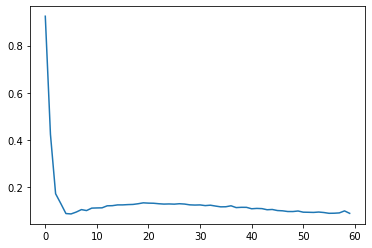

In [21]:
plt.plot(loss_history)

In [17]:
loss_history[-1]

0.08732563257217407